In [1]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import shap

X, y = shap.datasets.diabetes()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_test = X_test.reset_index(drop=True)
X_train_summary = shap.kmeans(X_train, 10)

nn = MLPRegressor(solver="lbfgs", alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(X_train, y_train)

def print_accuracy(f):
    print(
        f"Root mean squared test error = {np.sqrt(np.mean((f(X_test) - y_test) ** 2))}"
    )
    time.sleep(0.5)  # to let the print get out before any progress bars

print_accuracy(nn.predict)

C:\repositories\feature\venv11\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Root mean squared test error = 58.13233529996922


In [2]:
def my_predict(X):
    return nn.predict(X)

C:\repositories\feature\venv11\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


  0%|          | 0/89 [00:00<?, ?it/s]

C:\repositories\feature\venv11\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
C:\repositories\feature\venv11\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
C:\repositories\feature\venv11\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
C:\repositories\feature\venv11\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
C:\repositories\feature\venv11\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
C:\repositories\feature\venv11\Lib\site-packages\sklearn\base.py:493: UserWarnin

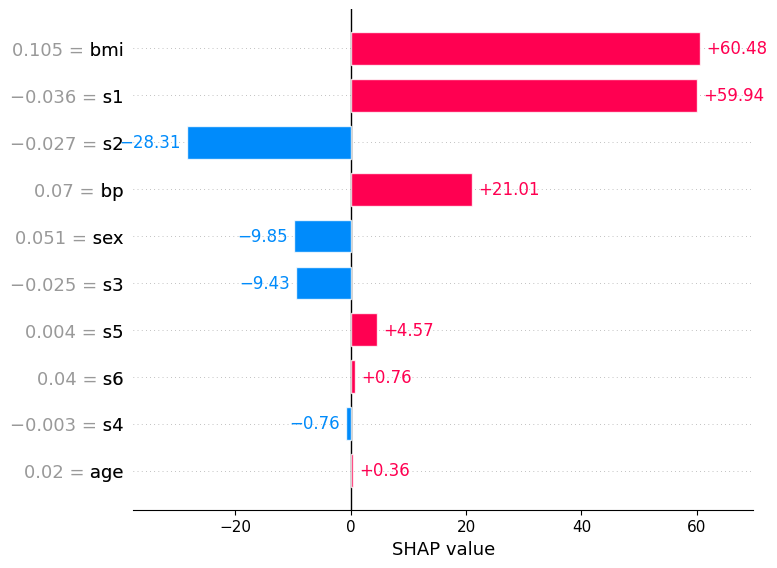

In [26]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(my_predict, X_train_summary)
shap_values = explainer(X_test)
shap.plots.bar(shap_values[0])

In [106]:
import pandas as pd

# do the same changes to multiple data frames
def combine_columns(df, columns):
    #combine column names to a string
    combined_name = ', '.join(columns)
    #combine the columns
    df[combined_name] = df.apply(lambda x: tuple(x[columns]), axis=1)
    #delete the original columns
    df = df.drop(columns, axis=1)
    
    return df

def split_columns(df, combined_name):
    #get the original names
    columns = combined_name.split(', ')
    #split the combined column
    df = pd.concat([df, df[combined_name].apply(pd.Series)], axis=1)
    #delete the combined column
    df = df.drop(combined_name, axis=1)
    #rename the newly created columns
    df.columns = df.columns[:len(df.columns)-len(columns)].tolist() + columns
    return df

def split_all_columns(df):
    tmp = df
    #split all combined columns
    for column in tmp.columns:
        if column.find(", ") >= 0:
            tmp = split_columns(tmp, column)

    return tmp

def dimreduce_columns(df, combined_name):
    #split the combined column
    df[combined_name] = df[combined_name].apply(lambda x: ', '.join(map(lambda y: str(round(y, 2)),x)))
    return df

def dimreduce_all_columns(df):
    tmp = pd.DataFrame(df)
    #split all combined columns
    for column in tmp.columns:
        if isinstance(tmp[column][0],tuple):
            tmp = dimreduce_columns(tmp, column)

    return np.array(tmp)



In [99]:
COLUMNS = X_train.columns

def detangled_predict(data):
    tmp = data
    tmp = split_all_columns(tmp)

    tmp = tmp.reindex(columns=COLUMNS)
    return nn.predict(tmp)

In [6]:
#convert x_train_summary from DenseData to DataFrame
X_train_means = X_train.mean().to_frame().T


In [114]:
#entangle the named columns
COL_LIST = ['s1', 's2', 's3', 's4', 's5', 's6']
tmp_X_test = X_test.copy()
tmp_X_test = combine_columns(tmp_X_test, COL_LIST)
tmp_X_train_means = X_train_means.copy()
tmp_X_train_means = combine_columns(tmp_X_train_means, COL_LIST)

explainer = shap.KernelExplainer(detangled_predict, tmp_X_train_means, COLUMNS, keep_index=True)
shap_values = explainer(tmp_X_test)
shap_values.data = dimreduce_all_columns(shap_values.data)

  0%|          | 0/89 [00:00<?, ?it/s]

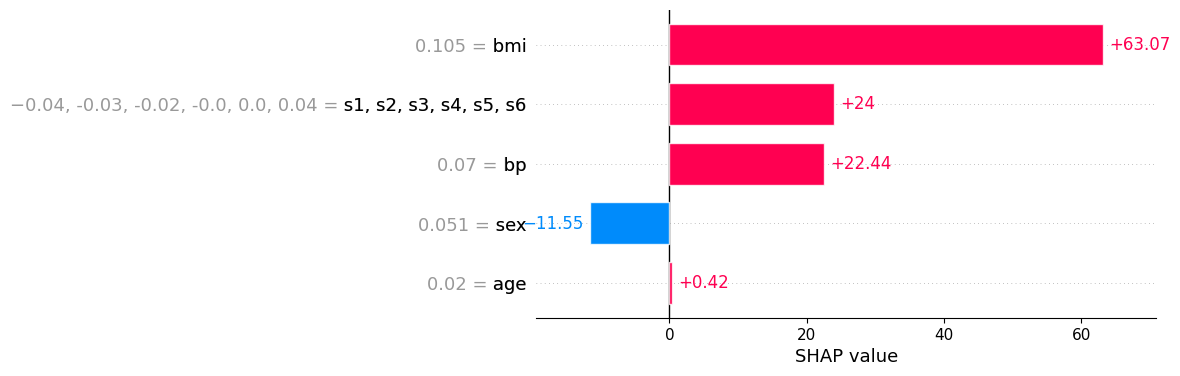

In [115]:
shap.plots.bar(shap_values[0])

In [ ]:
tmp_X_test = X_test.copy()
tmp_X_test = combine_columns(tmp_X_test, ['s1', 's2'])
detangled_predict(tmp_X_test.sample(n=1))


In [29]:
tmp_X_test = X_test.copy()
tmp_X_test = combine_columns(tmp_X_test, ['s1', 's2'])
#tmp_X_test = split_columns(tmp_X_test, 's1, s2')
#tmp_X_test
tmp_X_test['s1, s2'] = tmp_X_test['s1, s2'].apply(lambda x: ', '.join(map(str, x)))
tmp_X_test

,age,sex,bmi,bp,s3,s4,s5,s6,"s1, s2"
0,0.019913,0.050680,0.104809,0.070072,-0.024993,-0.002592,0.003709,0.040343,"-0.035967781275239266, -0.02667890283117104"
1,-0.012780,-0.044642,0.060618,0.052858,-0.017629,0.034309,0.070207,0.007207,"0.04796534307502911, 0.02937467182915568"
2,0.038076,0.050680,0.008883,0.042529,-0.039719,-0.002592,-0.018114,0.007207,"-0.04284754556624487, -0.02104223051895942"
3,-0.012780,-0.044642,-0.023451,-0.040099,-0.017629,-0.002592,-0.038460,-0.038357,"-0.016704441260423575, 0.00463594334778245"
4,-0.023677,-0.044642,0.045529,0.090729,0.070730,-0.039493,-0.034522,-0.009362,"-0.018080394118624697, -0.03544705976127803"
...,...,...,...,...,...,...,...,...,...
84,-0.070900,0.050680,-0.089197,-0.074527,-0.032356,-0.002592,-0.012909,-0.054925,"-0.04284754556624487, -0.02573945744580244"
85,0.001751,-0.044642,-0.070875,-0.022885,0.026550,-0.039493,-0.022517,0.007207,"-0.001568959820211247, -0.0010007289644291908"
86,-0.074533,-0.044642,0.043373,-0.033213,0.063367,-0.039493,-0.027129,-0.046641,"0.01219056876179996, 0.00025186488272894433"
87,-0.041840,0.050680,0.014272,-0.005670,-0.072854,0.071210,0.035459,-0.013504,"-0.012576582685820214, 0.0062016856567301245"
